In [2]:
!pip install scikit-multiflow
# !pip install river

     |████████████████████████████████| 1.1 MB 892 kB/s eta 0:00:01


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualisation imports
import plotly.express as px
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# sklearn
from sklearn.preprocessing import LabelEncoder

# scikit-multiflow
from skmultiflow.data import FileStream
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.evaluation import EvaluatePrequential

# scikit-multiflow drift detection
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.drift_detection import ADWIN
from skmultiflow.drift_detection import KSWIN
from skmultiflow.drift_detection import HDDM_A
from skmultiflow.drift_detection import HDDM_W
from skmultiflow.drift_detection import DDM

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
!python --version

Python 3.7.10


In [5]:
list_col = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
    
# loading nsl-kdd data
def load_nsl_data(path_to_file):

    df = pd.read_csv(path_to_file, header = 0, names = list_col, index_col = False)
    
    return df


# label encoding the data
def label_encode_df(df):
    # need to be encoded - protocol_type, service, flag, class
    df_encoded = df
    labelEncoder = LabelEncoder()
    df_encoded['protocol_type'] = labelEncoder.fit_transform(df['protocol_type'])
    df_encoded['service'] = labelEncoder.fit_transform(df['service'])
    df_encoded['flag'] = labelEncoder.fit_transform(df['flag'])
    df_encoded['class'] = labelEncoder.fit_transform(df['class'])
    
    return df_encoded

In [12]:
# loading dataset source files
df = load_nsl_data('/kaggle/input/nslkdd/KDDTrain+.txt')
df_test = load_nsl_data('/kaggle/input/nslkdd/KDDTest+.txt')

# converting data to binary labelled data
df.loc[df['class'] != 'normal', 'class'] = 'attack'
df_test.loc[df_test['class'] != 'normal', 'class'] = 'attack'

# label encoding datasets
df = label_encode_df(df)
df_test = label_encode_df(df_test)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning:

Length of header or names does not match length of data. This leads to a loss of data with index_col=False.



In [13]:
# training dataset
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,1
1,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,0
2,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,1
3,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1
4,0,1,49,1,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,0


In [14]:
# testing dataset
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,45,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,0
1,2,1,19,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,1
2,0,0,13,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,0
3,1,1,55,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,0
4,0,1,22,9,267,14515,0,0,0,0,...,255,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,1


In [15]:
# shape - train, test
df.shape, df_test.shape

((125972, 42), (22543, 42))

In [33]:
# # frequency of each class in training
# class_freq = df['class'].value_counts()
# print(class_freq)

# # viz for frequency
# fig = px.bar(x = class_freq.keys(), y = class_freq.values)
# fig.update_layout(font_family="Times New Roman", xaxis_title = "Classes", yaxis_title = "Frequency")

0    12832
1     9711
Name: class, dtype: int64


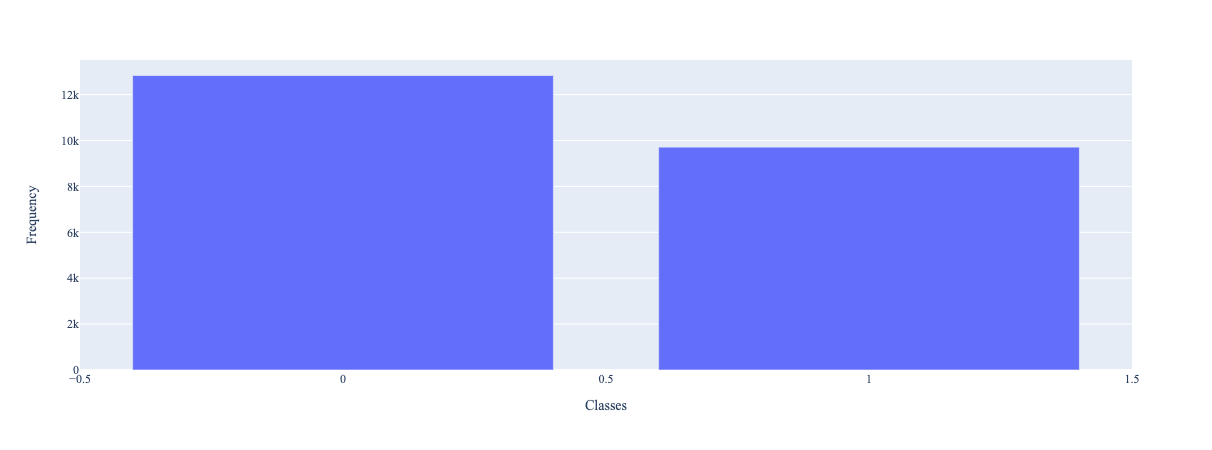

In [31]:
# frequency of each class in testing
class_freq_test = df_test['class'].value_counts()
print(class_freq_test)

# viz for frequency
fig = px.bar(x = class_freq_test.keys(), y = class_freq_test.values)
fig.update_layout(font_family="Times New Roman", xaxis_title = "Classes", yaxis_title = "Frequency")

In [24]:
# exporting train and test DataFrames as CSV files
df.to_csv('nsl_kdd_train.csv')
df_test.to_csv('nsl_kdd_test.csv')

In [25]:
# generating data streams from CSV files
train_file_stream = FileStream('nsl_kdd_train.csv')
test_file_stream = FileStream('nsl_kdd_test.csv')

In [26]:
# Adaptive Random Forest with no Drift Detection
arf_None = AdaptiveRandomForestClassifier(drift_detection_method = None, warning_detection_method = None)

# Adaptive Random Forest with Page Hinkley
arf_PageHinkley = AdaptiveRandomForestClassifier(drift_detection_method = PageHinkley(), warning_detection_method = PageHinkley())

# Adaptive Random Forest with ADWIN
arf_ADWIN = AdaptiveRandomForestClassifier(drift_detection_method = ADWIN(), warning_detection_method = ADWIN())

# Adaptive Random Forest with KSWIN
arf_KSWIN = AdaptiveRandomForestClassifier(drift_detection_method = KSWIN(), warning_detection_method = KSWIN())

# Adaptive Random Forest with HDDM_A
arf_HDDM_A = AdaptiveRandomForestClassifier(drift_detection_method = HDDM_A(), warning_detection_method = HDDM_A())

# Adaptive Random Forest with HDDM_W
arf_HDDM_W = AdaptiveRandomForestClassifier(drift_detection_method = HDDM_W(), warning_detection_method = HDDM_W())

# Adaptive Random Forest with DDM
arf_DDM = AdaptiveRandomForestClassifier(drift_detection_method = DDM(), warning_detection_method = DDM())

In [ ]:
# # training data stream evaluation
# evaluator_train = EvaluatePrequential(pretrain_size = 1000, max_samples = 125972, output_file = 'results_train.csv', metrics = ['accuracy', 'f1'])
# evaluator_train.evaluate(
#     stream = train_file_stream, 
#     model = [arf_None, arf_PageHinkley, arf_ADWIN, arf_KSWIN, arf_HDDM_A, arf_HDDM_W, arf_DDM], 
#     model_names = ['arf_None', 'arf_PageHinkley', 'arf_ADWIN', 'arf_KSWIN', 'arf_HDDM_A', 'arf_HDDM_W', 'arf_DDM']
# )

In [32]:
# testing data stream evaluation
evaluator_test = EvaluatePrequential(
    pretrain_size = 1000, 
    max_samples = 22543, 
    output_file = 'results_test.csv', 
    metrics = ['accuracy', 'f1']
)
evaluator_test.evaluate(
    stream = test_file_stream, 
    model = [arf_None, arf_PageHinkley, arf_ADWIN, arf_KSWIN, arf_HDDM_A, arf_HDDM_W, arf_DDM], 
    model_names = ['arf_None', 'arf_PageHinkley', 'arf_ADWIN', 'arf_KSWIN', 'arf_HDDM_A', 'arf_HDDM_W', 'arf_DDM']
)

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:7475: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.



Evaluating...
 #################### [100%] [1739.09s]
Processed samples: 22543
Mean performance:
arf_None - Accuracy     : 0.9831
arf_None - F1 score: 0.9803
arf_PageHinkley - Accuracy     : 0.9836
arf_PageHinkley - F1 score: 0.9809
arf_ADWIN - Accuracy     : 0.9655
arf_ADWIN - F1 score: 0.9592
arf_KSWIN - Accuracy     : 0.9824
arf_KSWIN - F1 score: 0.9795
arf_HDDM_A - Accuracy     : 0.9836
arf_HDDM_A - F1 score: 0.9809
arf_HDDM_W - Accuracy     : 0.9832
arf_HDDM_W - F1 score: 0.9805
arf_DDM - Accuracy     : 0.9836
arf_DDM - F1 score: 0.9809


[AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_method=None, grace_period=50,
                                lambda_value=6, leaf_prediction='nba',
                                max_byte_size=33554432, max_features=6,
                                memory_estimate_period=2000000, n_estimators=10,
                                nb_threshold=0, no_preprune=False,
                                nominal_attributes=None,
                                performance_metric='acc', random_state=None,
                                remove_poor_atts=False, split_confidence=0.01,
                                split_criterion='info_gain',
                                stop_mem_management=False, tie_threshold=0.05,
                                warning_detection_method=None),
 AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_meth

In [65]:
df_test_results = pd.read_csv('results_test.csv', skiprows = 11)
df_test_results.tail(1)

,id,mean_acc_[arf_None],current_acc_[arf_None],mean_acc_[arf_PageHinkley],current_acc_[arf_PageHinkley],mean_acc_[arf_ADWIN],current_acc_[arf_ADWIN],mean_acc_[arf_KSWIN],current_acc_[arf_KSWIN],mean_acc_[arf_HDDM_A],...,mean_f1_[arf_ADWIN],current_f1_[arf_ADWIN],mean_f1_[arf_KSWIN],current_f1_[arf_KSWIN],mean_f1_[arf_HDDM_A],current_f1_[arf_HDDM_A],mean_f1_[arf_HDDM_W],current_f1_[arf_HDDM_W],mean_f1_[arf_DDM],current_f1_[arf_DDM]
112,22542,0.983057,0.975,0.983568,0.98,0.965511,0.97,0.982407,0.98,0.983614,...,0.959223,0.965517,0.97947,0.977273,0.98091,0.977273,0.980481,0.971751,0.980877,0.983051


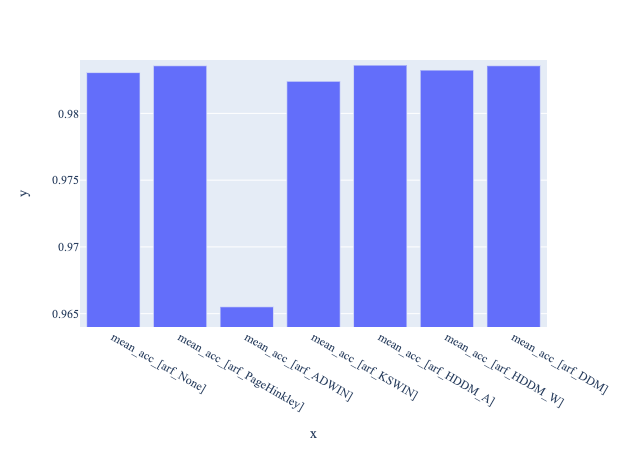

In [89]:
# mean accuracies
fig = px.bar(x = df_test_results.iloc[112,1:15:2].keys(), y = df_test_results.iloc[112,1:15:2].values, range_y = [0.964, 0.984])
fig.update_layout(
    font_family="Times New Roman",
)

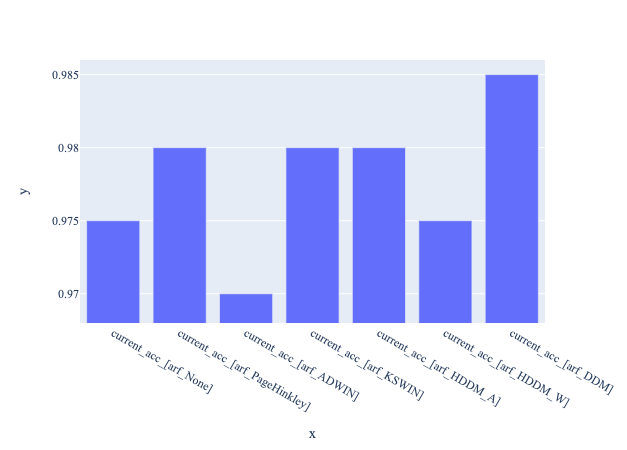

In [90]:
# current accuracies
fig = px.bar(x = df_test_results.iloc[112,2:16:2].keys(), y = df_test_results.iloc[112,2:16:2].values, range_y = [0.968, 0.986])
fig.update_layout(
    font_family="Times New Roman",
)

In [80]:
df_test_results.iloc[112,:]

id                               22542.000000
mean_acc_[arf_None]                  0.983057
current_acc_[arf_None]               0.975000
mean_acc_[arf_PageHinkley]           0.983568
current_acc_[arf_PageHinkley]        0.980000
mean_acc_[arf_ADWIN]                 0.965511
current_acc_[arf_ADWIN]              0.970000
mean_acc_[arf_KSWIN]                 0.982407
current_acc_[arf_KSWIN]              0.980000
mean_acc_[arf_HDDM_A]                0.983614
current_acc_[arf_HDDM_A]             0.980000
mean_acc_[arf_HDDM_W]                0.983243
current_acc_[arf_HDDM_W]             0.975000
mean_acc_[arf_DDM]                   0.983568
current_acc_[arf_DDM]                0.985000
mean_f1_[arf_None]                   0.980271
current_f1_[arf_None]                0.971429
mean_f1_[arf_PageHinkley]            0.980861
current_f1_[arf_PageHinkley]         0.977778
mean_f1_[arf_ADWIN]                  0.959223
current_f1_[arf_ADWIN]               0.965517
mean_f1_[arf_KSWIN]               

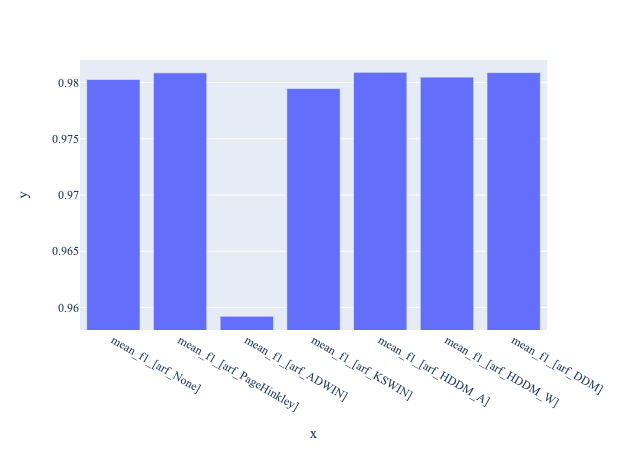

In [91]:
# mean f1
fig = px.bar(x = df_test_results.iloc[112,15:30:2].keys(), y = df_test_results.iloc[112,15:30:2].values, range_y = [0.958, 0.982])
fig.update_layout(
    font_family="Times New Roman",
)

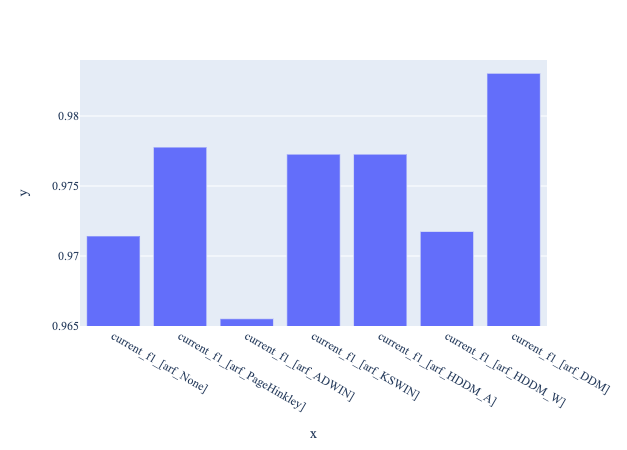

In [92]:
# current f1
fig = px.bar(x = df_test_results.iloc[112,16:30:2].keys(), y = df_test_results.iloc[112,16:30:2].values, range_y = [0.965, 0.984])
fig.update_layout(
    font_family="Times New Roman",
)

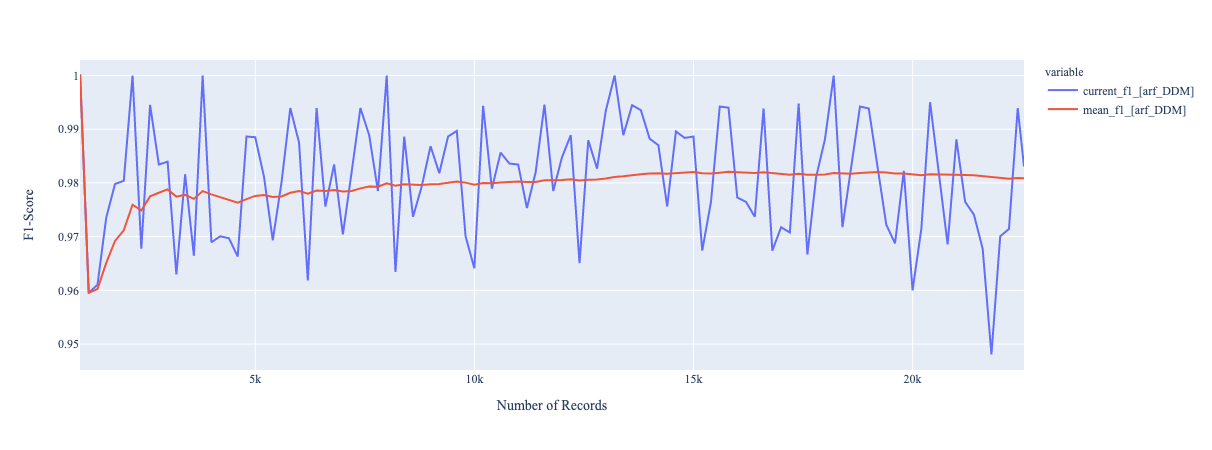

In [96]:
# DDM
fig = px.line(df_test_results, y=['current_f1_[arf_DDM]', 'mean_f1_[arf_DDM]'], x="id")
fig.update_layout(font_family="Times New Roman", xaxis_title = "Number of Records", yaxis_title = "F1-Score")
fig.show()

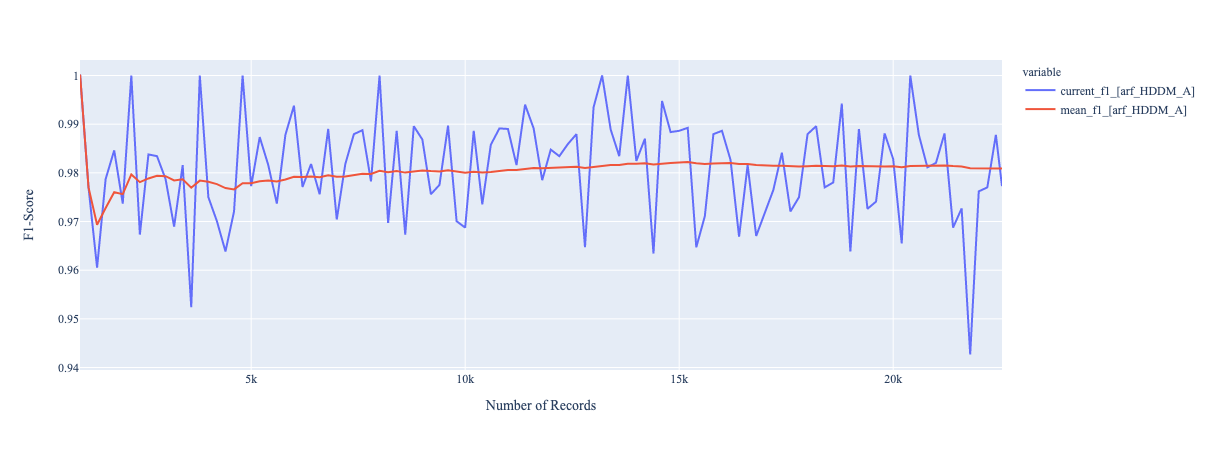

In [99]:
# page hinkley
fig = px.line(df_test_results, y=['current_f1_[arf_HDDM_A]', 'mean_f1_[arf_HDDM_A]'], x="id")
fig.update_layout(font_family="Times New Roman", xaxis_title = "Number of Records", yaxis_title = "F1-Score")
fig.show()